In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [2]:
# Load Fashion MNIST data
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess: Flatten and scale
x_train = x_train.reshape(-1, 784).astype(np.float32)  # Flatten 28x28 to 784
x_test = x_test.reshape(-1, 784).astype(np.float32)
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

# Normalize data for cosine similarity
X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_train_normalized = X_train_normalized.astype(np.float32)

In [3]:
# Parameters
epsilon = 1e-4  # Convergence tolerance
t_max = 20      # Max iterations (reduced for speed)
learning_rate = 0.05
w_0 = np.random.randn(784, 10)  # Initial weights
lambda_values = [0.1, 0.5, 1.0]  # Compression factors
n_bits = 16     # Hash bits (tunable for speed vs. accuracy trade-off)
history_dict = {}
test_accuracies = {}

In [4]:
# Gradient computation using TensorFlow
def compute_gradient_tf(X, y, weights):
    weights_tf = tf.Variable(weights, dtype=tf.float32)
    with tf.GradientTape() as tape:
        logits = X @ weights_tf
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(y, depth=10), logits=logits
        ))
    gradient = tape.gradient(loss, weights_tf)
    return gradient.numpy()

In [5]:
# Hashing + Bucketing Algorithm
def hash_and_bucket(X, y, lambda_val, n_bits=16):
    n_samples = X.shape[0]
    n_features = X.shape[1]

    # Number of buckets based on lambda
    n_buckets = int(n_samples * lambda_val)
    if n_buckets < 10:  # Ensure at least 10 buckets for reasonable clustering
        n_buckets = 10

    # Random projection for LSH
    random_vectors = np.random.randn(n_bits, n_features).astype(np.float32)
    hash_codes = np.dot(X, random_vectors.T) > 0  # Binary hash codes (SimHash)

    # Convert binary hash codes to integers (bucket IDs)
    bucket_ids = np.packbits(hash_codes, axis=1, bitorder='little').view(np.uint16)
    bucket_ids = bucket_ids.flatten() % n_buckets  # Map to n_buckets

    # Initialize centroids and labels
    centroids = np.zeros((n_buckets, n_features), dtype=np.float32)
    h_k = np.zeros(n_buckets, dtype=np.uint8)
    bucket_counts = np.zeros(n_buckets, dtype=np.int32)

    # Compute centroids and majority labels
    for i in range(n_samples):
        bucket = bucket_ids[i]
        centroids[bucket] += X[i]
        bucket_counts[bucket] += 1

    # Avoid division by zero
    valid_buckets = bucket_counts > 0
    centroids[valid_buckets] /= bucket_counts[valid_buckets, np.newaxis]

    # Assign majority labels
    for bucket in range(n_buckets):
        if bucket_counts[bucket] > 0:
            cluster_labels = y[bucket_ids == bucket]
            h_k[bucket] = np.bincount(cluster_labels, minlength=10).argmax()

    return centroids, h_k, bucket_ids

In [6]:
# Main loop for each lambda
for lambda_val in lambda_values:
    start_time = time.time()
    print(f"\nProcessing lambda = {lambda_val}")

    # Hash and bucket
    centroids, h_k, bucket_ids = hash_and_bucket(X_train_normalized, y_train, lambda_val, n_bits)

    # Gradient descent to update centroids (lightweight)
    weights = w_0.copy()
    for iteration in range(t_max):
        previous_centroids = centroids.copy()
        for bucket_idx in np.unique(bucket_ids):
            cluster_points = X_train[bucket_ids == bucket_idx]
            cluster_labels = y_train[bucket_ids == bucket_idx]
            if len(cluster_points) > 0:
                original_gradient = compute_gradient_tf(cluster_points, cluster_labels, weights)
                compressed_gradient = compute_gradient_tf(centroids[bucket_idx].reshape(1, -1),
                                                        np.array([h_k[bucket_idx]]), weights)
                centroids[bucket_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)

        change = np.max(np.linalg.norm(centroids - previous_centroids, axis=1))
        if change <= epsilon:
            print(f"Converged at iteration {iteration}")
            break

    # Assign compressed data
    compressed_X = centroids
    compressed_y = h_k

    # Reshape for CNN (28x28x1)
    compressed_X_2d = compressed_X.reshape(-1, 28, 28, 1)
    X_test_2d = X_test.reshape(-1, 28, 28, 1)

    # Define a lightweight CNN
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train on compressed data
    history = model.fit(compressed_X_2d, compressed_y,
                        epochs=10,
                        verbose=1)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test_2d, y_test, verbose=0)

    # Store results
    history_dict[lambda_val] = history.history
    test_accuracies[lambda_val] = test_acc

    end_time = time.time()
    print(f"Lambda {lambda_val} - Time taken: {end_time - start_time:.2f}s, Test accuracy: {test_acc:.4f}")



Processing lambda = 0.1
Converged at iteration 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.3875 - loss: 1.7756
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6797 - loss: 0.9058
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7246 - loss: 0.8162
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7279 - loss: 0.7652
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7464 - loss: 0.7273
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7659 - loss: 0.6900
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7770 - loss: 0.6366
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7922 - loss: 0.5989
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7988 - loss: 0.5722
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8150 - loss: 0.5436
Lambda 0.1 - Time taken: 176.04s, Test accuracy: 0.9118

Processing lambda = 0.5
Converged at iteration 0
Epoch 1/10
938/938 ━

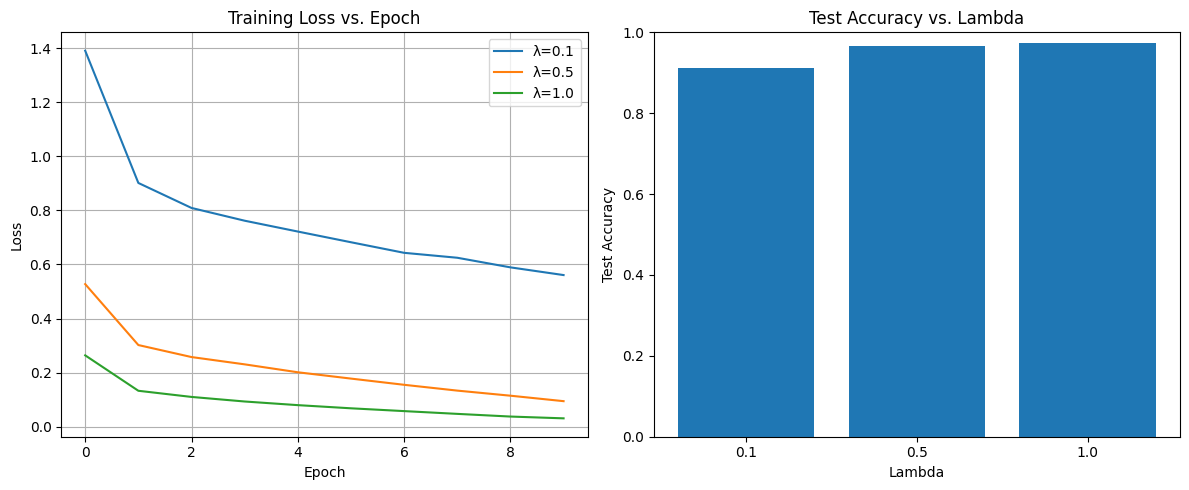

In [7]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for lambda_val, history in history_dict.items():
    plt.plot(history['loss'], label=f'λ={lambda_val}')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar([str(l) for l in lambda_values], test_accuracies.values())
plt.title('Test Accuracy vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()